# Fit BAO peak from input correlation function

In [1]:
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from cosmoprimo import *

from densitysplit import catalog_data, density_split
from bin.density_split_mocks_functions import split_density, compute_densitySplit_CCF
from densitysplit.pk_model import *
from densitysplit.utils import *
from densitysplit.corr_func import *

# To activate logging
setup_logging()

## Data and output directories

In [2]:
data_dir = '/feynman/work/dphp/mp270220/data/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Get data

In [3]:
#catalog_name = 'AbacusSummit_1Gpc_z1.175'
#bias = 1.8

catalog_name = 'AbacusSummit_2Gpc_z1.175'
#bias = 3.

#catalog_name = 'AbacusSummit_2Gpc_z0.800'
#catalog_name = 'mock'

catalog = catalog_data.Data.load(data_dir+catalog_name+'.npy')
catalog.shift_boxcenter(-catalog.offset)

In [4]:
z = catalog.redshift

# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()
f = bg.Omega_m(z)**0.55

## Load correlation function poles

In [5]:
ells = [0, 2]
nells = len(ells)

### Density split

In [6]:
nsplits = 3
nmocks = 1000
abacus_split_results = np.load(output_dir+catalog.name+'_densitySplit_hh_CCFs_cellsize10_randomsize4_RSD.npy', allow_pickle=True)
mocks_split_results = np.load(output_dir+'AbacusSummit_1Gpc_z1.175'+'_1000_mocks_densitySplit_hh_CCF_cellsize10_randomsize4_RSD_all.npy', allow_pickle=True)

In [7]:
_, split_cov = get_split_poles(mocks_split_results, ells, nsplits)
split_xiell = [abacus_split_results[split].get_corr(ells=ells, return_sep=False) for split in range(nsplits)]
split_cov /= 8

In [8]:
s, _ = abacus_split_results[0].get_corr(ells=ells, return_sep=True)

In [9]:
# Remove small scales (linear model not valid at small scales)
s_lower_limit = 50 # Mpc/h

ns = len(s[s > s_lower_limit])
# Hartlap correction
hartlap = (nmocks-1)/(nmocks-ns*nsplits*nells-2)
split_cov *= hartlap

## Set power spectrum model

In [10]:
pk_model = PkModel(sep=s, ells=ells, xiell=split_xiell, cov=split_cov, redshift=z, cosmology=cosmo_abacus, k=np.logspace(-3,2,1000), split=True, nsplits=nsplits)
pk_model.set_pk_model()
default_params = {'f': f, 'b1': 2., 'b2': 2., 'b3': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5., 'sigma_s': 4.}
pk_model.set_default_params(**default_params)
#pk_model.plot_model()

## Fit model to data

In [11]:
# initialize parameters
broadband_coeffs = np.tile([0., 0., 0.], nells)
params_init = {'b1': 2., 'b2': 2., 'b3': 2., 'alpha_par': 1., 'alpha_perp': 1., 'sigma_par': 5., 'sigma_perp': 5., 'broadband_coeffs1': broadband_coeffs, 'broadband_coeffs2': broadband_coeffs, 'broadband_coeffs3': broadband_coeffs}

pk_model.fit_splits(fit_params_init=params_init, s_lower_limit=s_lower_limit)

Optimal parameters:
{'b1': 0.11500366071718698, 'b2': 1.4743943868034104, 'b3': 2.029637108493373, 'alpha_par': 0.9781695550322466, 'alpha_perp': 1.0121104377583692, 'sigma_par': 5.269100957883644, 'sigma_perp': 3.237498219538861, 'broadband_coeffs1': array([-6.11502892e+01,  8.49998719e-01, -2.73476383e-03,  1.13783026e+01,
        5.40363556e-01, -3.54690183e-03]), 'broadband_coeffs2': array([ 2.57196527e+01, -4.60313671e-01,  1.87105703e-03,  1.52470732e+01,
       -4.99504089e-01,  2.89969648e-03]), 'broadband_coeffs3': array([ 1.47842485e+02, -2.10747889e+00,  6.95412435e-03, -5.25720545e+01,
       -1.51777340e+00,  1.03883630e-02])}

Covariance matrix:
[[ 3.29999885e-02  8.43688718e-03  1.70257143e-02  1.48810737e-04
  -3.57225329e-05  6.06563290e-03  8.67786017e-02  3.92683444e-01
  -4.59084832e-03  1.06811343e-05 -9.31374608e-01  2.33860766e-03
   9.61347760e-07 -4.11218822e-01  4.73629457e-03 -1.17176482e-05
   1.30340251e-01  1.47152650e-03 -9.34207033e-06 -1.21707553e+00
  

({'b1': 0.11500366071718698,
  'b2': 1.4743943868034104,
  'b3': 2.029637108493373,
  'alpha_par': 0.9781695550322466,
  'alpha_perp': 1.0121104377583692,
  'sigma_par': 5.269100957883644,
  'sigma_perp': 3.237498219538861,
  'broadband_coeffs1': array([-6.11502892e+01,  8.49998719e-01, -2.73476383e-03,  1.13783026e+01,
          5.40363556e-01, -3.54690183e-03]),
  'broadband_coeffs2': array([ 2.57196527e+01, -4.60313671e-01,  1.87105703e-03,  1.52470732e+01,
         -4.99504089e-01,  2.89969648e-03]),
  'broadband_coeffs3': array([ 1.47842485e+02, -2.10747889e+00,  6.95412435e-03, -5.25720545e+01,
         -1.51777340e+00,  1.03883630e-02])},
 array([[ 3.29999885e-02,  8.43688718e-03,  1.70257143e-02,
          1.48810737e-04, -3.57225329e-05,  6.06563290e-03,
          8.67786017e-02,  3.92683444e-01, -4.59084832e-03,
          1.06811343e-05, -9.31374608e-01,  2.33860766e-03,
          9.61347760e-07, -4.11218822e-01,  4.73629457e-03,
         -1.17176482e-05,  1.30340251e-01,  1.

[000068.92]  05-24 10:11  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000068.92]  05-24 10:11  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000068.92]  05-24 10:11  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000068.93]  05-24 10:11  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000069.08]  05-24 10:11  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000069.08]  05-24 10:11  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000069.09]  05-24 10:11  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000069.09]  05-24 10:11  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral


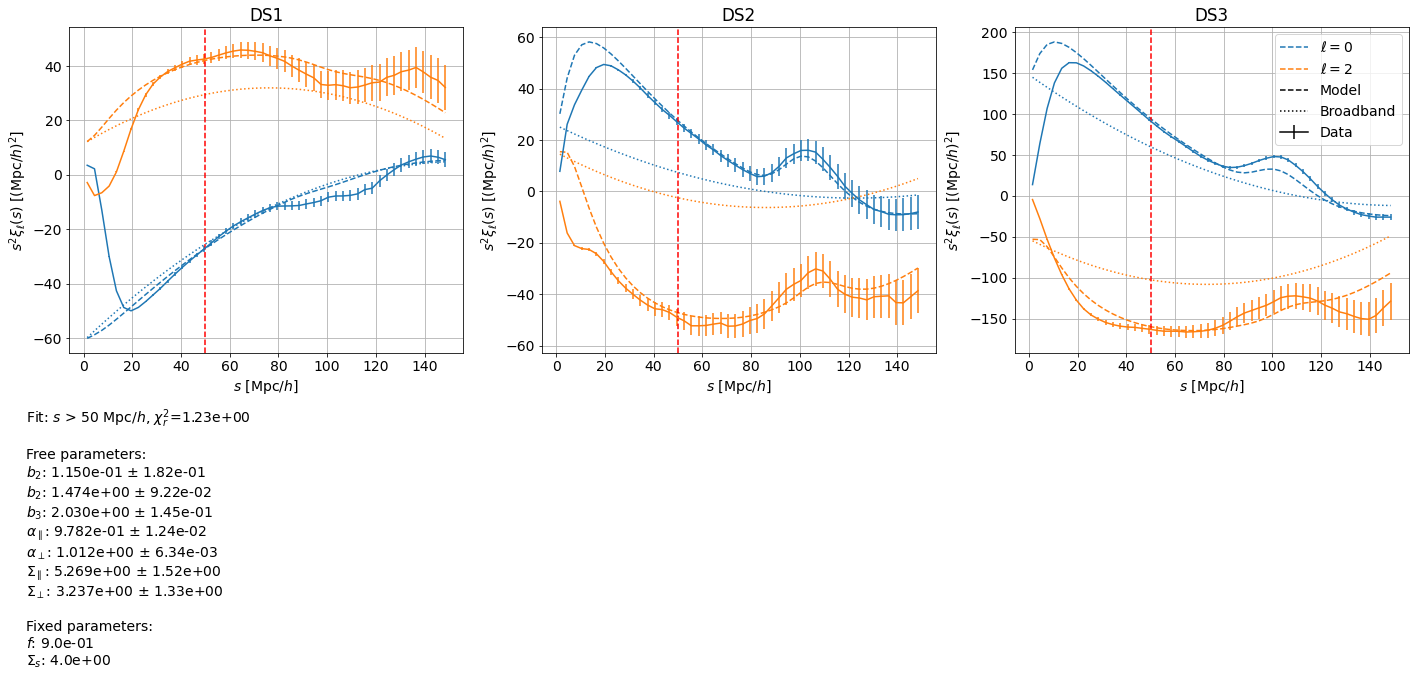

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6), sharey = False)

pk_model.plot_model_splits(fig=fig, axes=axes, plot_data=True, show_info=True, show_broadband=True)
#plt.title('Halos-halos')
plt.show()

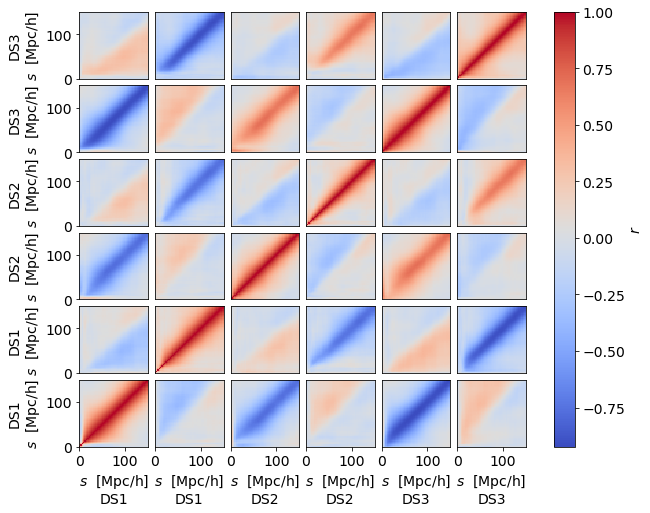

In [13]:
plot_corrcoef(split_cov, ells, s, nsplits)